### Longaandoeningen

In dit script ga ik een algoritme trainen die herkennen gaat hoe rookstatus het ziektebeeld en herstel voorspeld. De onderzoeksvraag die hierbij hoort is; 'Hoe beïnvloedt rookstatus het type longziekte en de kans op herstel?' <br>

De data heb ik via [Dataset lungdiseases](https://www.kaggle.com/datasets/samikshadalvi/lungs-diseases-dataset?resource=download) <br>

De dataset bevat de volgende categorieën: <br>
🧑‍🤝‍🧑 Leeftijd & Geslacht: Patiëntendemografie om de verspreiding over leeftijdsgroepen en geslacht te begrijpen.<br>
🚬 Rookstatus: Of de patiënt een roker of niet-roker is.<br>
🌡️ Longcapaciteit: Gemeten longfunctie om de ernst van de ziekte te beoordelen.<br>
🫁 Ziektetype: De specifieke longziekte, zoals COPD of bronchitis.<br>
💊 Behandelingstype: Verschillende behandelingen die patiënten hebben ontvangen, zoals therapie, medicatie of chirurgie.<br>
🏥 Ziekenhuisbezoeken: Aantal bezoeken aan het ziekenhuis voor het beheer van de aandoening.<br>
✅ Herstelstatus: Geeft aan of de patiënt hersteld is na de behandeling. <br>

Voor dit algoritme gebruik ik de categorische data Rookstatus, ziektetype, gender, age en herstelstatus

In [178]:
# Inladen benodigde libraries
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn as skl
from sklearn import tests as tests
from sklearn import metrics as metrics
import csv
import scipy.stats as stats
import statsmodels.api as sm

### Data inlezen

De data wordt eerst ingelezen door de eerste 5 regels van het bestand te laden en de header te scheiden van de rest van de data.

In [179]:
with open("lung_disease_data.csv", newline="", encoding="utf-8") as data_file:
    reader = csv.reader(data_file) # Maakt csv_reader object 
    header = next(reader) # Leest header regel

    for i, row in enumerate(reader):
        print(row)
        if i == 4: # Stopt na 5 rijen
            break

['71.0', 'Female', 'No', '4.49', 'COPD', 'Therapy', '14.0', 'Yes']
['34.0', 'Female', 'Yes', '', 'Bronchitis', 'Surgery', '7.0', 'No']
['80.0', 'Male', 'Yes', '1.95', 'COPD', '', '4.0', 'Yes']
['40.0', 'Female', 'Yes', '', 'Bronchitis', 'Medication', '1.0', 'No']
['43.0', 'Male', 'Yes', '4.6', 'COPD', 'Surgery', '', 'Yes']


De data bestaat uit 3 numerieke waarden, 3 nominale klassen en 2 booleans. De data is komma seperated en bevat geen header meer omdat ik deze eruit gehaald heb. <br>

Ik definieer een codebook op basis van de informatie zoals deze gegeven is in de data. <br>

In [180]:
codebook = {
    "attribute":[
        "Age",
        "Gender",
        "Smoking status",
        "Lung capacity",
        "Disease type",
        "Treatment type",
        "Hospital visits",
        "Recovery status"
    ],
    "unit":[
        "years",
        "N/A",
        "N/A",
        "liters",
        "N/A",
        "N/A",
        "count",
        "N/A"
    ],
    "dtype":[
        "float32",
        "string",
        "bool",
        "float32",
        "category",
        "category",
        "int32",
        "bool"
    ],
    "beschrijving": [
        "Leeftijd van de patiënt in jaren.",
        "Geslacht van de patiënt.",
        "Geeft aan of de patiënt een roker is (Ja/Nee).",
        "Gemeten longcapaciteit in liters.",
        "De diagnose van de patiënt.",
        "Type behandeling dat de patiënt heeft ontvangen.",
        "Aantal ziekenhuisbezoeken voor deze aandoening.",
        "Geeft aan of de patiënt hersteld is na de behandeling (Ja/Nee)."
    ]    
}

pd.DataFrame(codebook).set_index("attribute")


,unit,dtype,beschrijving
attribute,,,
Age,years,float32,Leeftijd van de patiënt in jaren.
Gender,N/A,string,Geslacht van de patiënt.
Smoking status,N/A,bool,Geeft aan of de patiënt een roker is (Ja/Nee).
Lung capacity,liters,float32,Gemeten longcapaciteit in liters.
Disease type,N/A,category,De diagnose van de patiënt.
Treatment type,N/A,category,Type behandeling dat de patiënt heeft ontvangen.
Hospital visits,count,int32,Aantal ziekenhuisbezoeken voor deze aandoening.
Recovery status,N/A,bool,Geeft aan of de patiënt hersteld is na de beha...


Conclusie; het codebook is correct gedefinieerd en geschikt om mee verder te werken.

Ik ga nu de data inlezen en ik heb een nieuwe key "label" toegevoegd aan het codebook. De waarde van "label" is een lijst waarin bijvoorbeeld attributen en units worden samengevoegd zodat de labels beter leesbaar en bruikbaar zijn voor tabellen en visualisaties. 

In [181]:
codebook["label"] = [f"{attribute} [{unit}]" for attribute, unit in zip(codebook["attribute"], codebook["unit"])]

longdata = pd.read_csv("./lung_disease_data.csv", header=None, names=codebook["label"])
longdata.index +=1 # Leest de data vanaf regel 1


longdata.head()

,Age [years],Gender [N/A],Smoking status [N/A],Lung capacity [liters],Disease type [N/A],Treatment type [N/A],Hospital visits [count],Recovery status [N/A]
1,Age,Gender,Smoking Status,Lung Capacity,Disease Type,Treatment Type,Hospital Visits,Recovered
2,71.0,Female,No,4.49,COPD,Therapy,14.0,Yes
3,34.0,Female,Yes,NaN,Bronchitis,Surgery,7.0,No
4,80.0,Male,Yes,1.95,COPD,NaN,4.0,Yes
5,40.0,Female,Yes,NaN,Bronchitis,Medication,1.0,No


Verificatie uitvoeren of alle rijen en kolommen zijn ingelezen.

In [182]:
longdata.shape

(5201, 8)

Alle rijen en kolommen zijn ingelezen.

Nu zet ik de kolommen die ik ga gebruiken in het machine learning model om in de meest geschikte datatypen, ik licht mijn keuzes toe. <br>


Voor **Smoking Status** gebruik ik **category** (ja/nee) omdat categorische waarden makkelijker te verwerken zijn dan objecten.<br>
Voor **Disease type** gebruik ik **category** omdat categorische waarden makkelijker te verwerken zijn dan objecten.<br>
Voor **Recovery status** gebruik ik **category** (yes/no) omdat categorische waarden makkelijker te verwerken zijn dan objecten.<br>
Voor **Age** gebruik ik **float** omdat de data al in dit format staat.
Voor **Gender** gebruik ik **category?** (Female/Male) omdat categorische waarden makkelijker te verwerken zijn dan objecten.<br>


Ik ga de kolomnamen laten controleren zodat ik zeker weet dat ik de goede namen pak om te kunnen aanpassen.

In [183]:
longdata.columns # controleren van kolomnamen, alvorens aan te passen

Index(['Age [years]', 'Gender [N/A]', 'Smoking status [N/A]',
       'Lung capacity [liters]', 'Disease type [N/A]', 'Treatment type [N/A]',
       'Hospital visits [count]', 'Recovery status [N/A]'],
      dtype='object')

In [184]:
df = longdata

df["Smoking status [N/A]"] = df["Smoking status [N/A]"].astype("category")
df["Disease type [N/A]"] = df["Disease type [N/A]"].astype("category")
df["Recovery status [N/A]"] = df["Recovery status [N/A]"].astype("category")
df['Age [years]'] = df['Age [years]']
df['Gender [N/A]'] = df['Gender [N/A]'].astype("category")

# Niet relevante kolommen verwijderen
#df = df.drop(columns=["Lung capacity [liters]", "Treatment type [N/A]", "Hospital visits [count]"])

longdata = df
longdata = longdata.iloc[1:]

print(longdata.head())

  Age [years] Gender [N/A] Smoking status [N/A] Lung capacity [liters]  \
2        71.0       Female                   No                   4.49   
3        34.0       Female                  Yes                    NaN   
4        80.0         Male                  Yes                   1.95   
5        40.0       Female                  Yes                    NaN   
6        43.0         Male                  Yes                    4.6   

  Disease type [N/A] Treatment type [N/A] Hospital visits [count]  \
2               COPD              Therapy                    14.0   
3         Bronchitis              Surgery                     7.0   
4               COPD                  NaN                     4.0   
5         Bronchitis           Medication                     1.0   
6               COPD              Surgery                     NaN   

  Recovery status [N/A]  
2                   Yes  
3                    No  
4                   Yes  
5                    No  
6         

Conclusie, de data is correct ingelezen en geschikt om mee verder te werken.

### Exploratieve data analyse Univeraat

Er zijn op het oog geen ontbrekende of ongeldige waarden. Dit controleer ik alsvolgt. Ik zet eerst alle afwijkende en ontbrekende waarden om naar NaN-waarden omdat panda's deze goed herkent.

In [185]:
longdata = longdata.replace(["", "N/A", "-", " ", "NaN", "nan", "None"], None) # Waarden omzetten

longdata_gefilterd = longdata[longdata.isna().sum(axis=1) < 3] # Alle rijen verwijderen waar 2 of meer missende waarden zijn

# Lege waarden opvullen 
for col in longdata_gefilterd.columns:
    mode_value = longdata_gefilterd[col].mode().iloc[0] # De meest voorkomende waarde selecteren
    longdata_gefilterd[col].fillna(mode_value, inplace=True) # Vervang de afwijkende data met de meest voorkomende waarde

# Controleren of er nog ontbrekende/afwijkende waarden zijn
pd.DataFrame({
    "isna": longdata_gefilterd.isna().sum()
})


C:\Users\janin\AppData\Local\Temp\ipykernel_22172\3297555082.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  longdata_gefilterd[col].fillna(mode_value, inplace=True) # Vervang de afwijkende data met de meest voorkomende waarde


,isna
Age [years],0
Gender [N/A],0
Smoking status [N/A],0
Lung capacity [liters],0
Disease type [N/A],0
Treatment type [N/A],0
Hospital visits [count],0
Recovery status [N/A],0


Conclusie, na grondig filteren, het verwijderen en het vervangen van de afwijkende waarden zijn er geen afwijkende of ontbrekende waarden meer over.

### Rookstatus

Ik ga kijken hoe de verdeling is van de rokers versus de niet rokers.

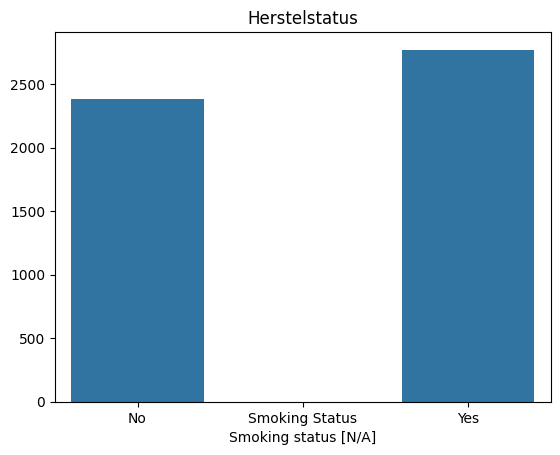

In [186]:
# Verdeling rokers versus niet rokers
rookstatus_counts = longdata_gefilterd["Smoking status [N/A]"].value_counts()

# Histogram maken van frequenties
sns.barplot(x=rookstatus_counts.index, y=rookstatus_counts.values)

# Titel histogram
plt.title("Herstelstatus")

plt.show()


Conclusie; er zijn meer rokers dan niet rokers aanwezig in de dataset.

Ik ga kijken wat de verdeling is van de ziektebeelden.

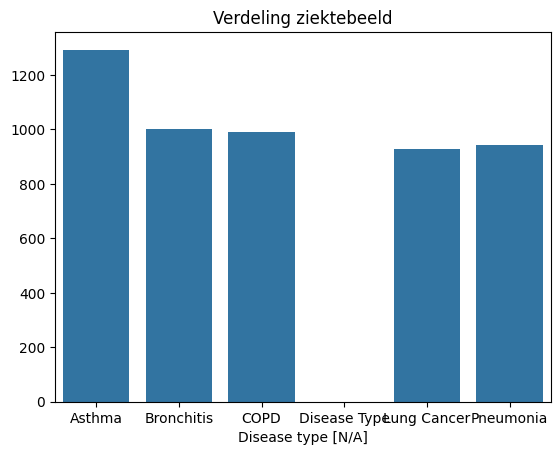

In [187]:
# Frequenties van verschillende categoriën berekenen
category_counts = longdata_gefilterd["Disease type [N/A]"].value_counts()

# Histogram maken van frequenties
sns.barplot(x=category_counts.index, y=category_counts.values)

# Titel histogram
plt.title("Verdeling ziektebeeld")

plt.show()

Conclusie; De ziektebeelden komen bijna allemaal een gelijkwaardig aantal keren voor, met uitzondering Bronchitis, deze steekt er ruim bovenuit.

Ik ga kijken wat de verdeling is van de herstelstatus.

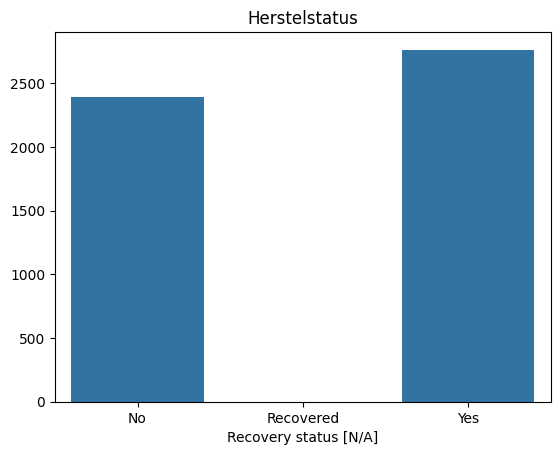

In [188]:
# Frequenties van verschillende categoriën berekenen
category_counts = longdata_gefilterd["Recovery status [N/A]"].value_counts()

# Histogram maken van frequenties
sns.barplot(x=category_counts.index, y=category_counts.values)

# Titel histogram
plt.title("Herstelstatus")

plt.show()

Conclusie; Er zijn meer herstelde personen dan niet herstelde personen in deze dataset.

### Verband tussen rookstatus en herstelstatus

Om te kijken wat de correlaties zijn tussen rook en herstelstatus ga ik een heatmap maken.

Recovery status [N/A]    No   Yes
Smoking status [N/A]             
No                     1079  1307
Yes                    1314  1457


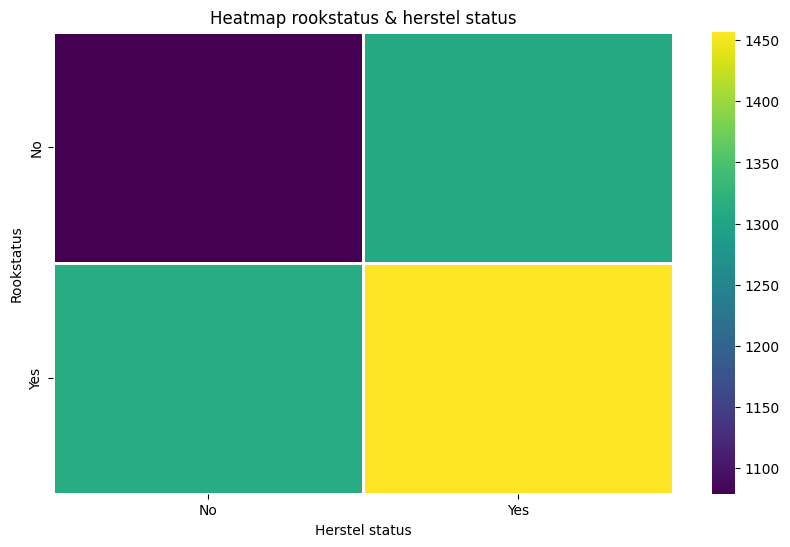

In [189]:
# Kruistabel maken van de 2 categorieën
cross_tab = pd.crosstab(index=longdata_gefilterd['Smoking status [N/A]'], 
                        columns=longdata_gefilterd['Recovery status [N/A]'])

print(cross_tab)

# Heatmap plotten
plt.figure(figsize=(10, 6)) # Grootte van plot aanpassen
sns.heatmap(cross_tab, linewidths=1, cmap="viridis")

plt.title("Heatmap rookstatus & herstel status")
plt.xlabel("Herstel status")
plt.ylabel("Rookstatus")
plt.show()

Conclusie; In deze heatmap is duidelijk te zien dat rook en herstelstatus wel degelijk met elkaar te maken hebben.  
- Wel rokend, wel hersteld heeft de hoogste hoeveelheid.  
- Wel rokend, niet hersteld heeft een medium hoeveelheid.  
- Niet rokend, niet hersteld heeft een lage hoeveelheid.  
- Niet rokend, wel hersteld heeft een medium hoveelheid.   

Hier valt vanaf te leiden dat de categorie wel hersteld, ongeacht rookstatus, de hoogste hoeveelheid heeft. Waarin de categorie wel rokers wel hersteld de hoogste hoeveelheid bevat.

### Exploratieve data analyse bivariate analyses
Ik ga kijken wat de verdeling van de rookstatus is per ziektebeeld.

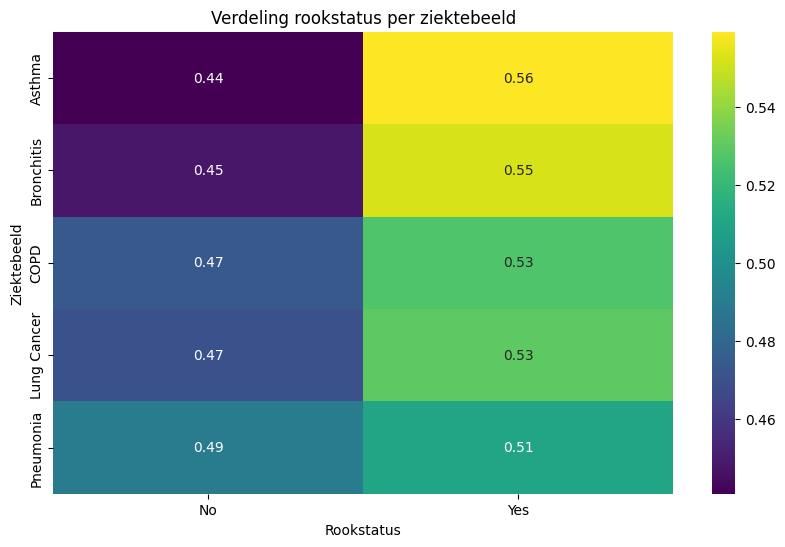

In [190]:
# Verdeling per ziektebeeld
rookstatus_ziektebeeld = pd.crosstab(longdata_gefilterd['Disease type [N/A]'],
                                     longdata_gefilterd['Smoking status [N/A]'],
                                     normalize='index')

# Heatmap rookstatus en ziektebeeld
plt.figure(figsize=(10, 6))
sns.heatmap(rookstatus_ziektebeeld, annot=True, cmap="viridis")
plt.title("Verdeling rookstatus per ziektebeeld")
plt.xlabel("Rookstatus")
plt.ylabel("Ziektebeeld")
plt.show()

Conclusie: Wanneer een patiënt rookt komen de ziektebeelden Astma en Bronchitis het vaakste voor, bij niet rokende patiënten komen de ziektebeelden Pneunomia (longontsteking) en COPD/Longkanker het vaakste voor.

### Chi-square test
Ik ga de chi-square test toepassen om te bepalen of er een statistisch significant verband bestaat tussen de twee categorische variabelen rookstatus en ziektebeeld.

In [191]:
# Kruistabel maken
kruistabel = pd.crosstab(longdata_gefilterd['Smoking status [N/A]'],
                         longdata_gefilterd['Disease type [N/A]'])

# Chi-square test uitvoeren
chi2, p, dof, expected = stats.chi2_contingency(kruistabel)

result_kruistabel = pd.DataFrame({
    "Chi-square waarde": [chi2],
    "P-waarde": [p],
    "Vrijheidsgraden": [dof]
})

result_kruistabel

,Chi-square waarde,P-waarde,Vrijheidsgraden
0,6.709055,0.152086,4


Conclusie; De P-waarde is 0.1751, omdat deze groter is dan 0.05 kan ik niet met zekerheid zeggen dat rookstatus en ziektebeeld een significante relatie hebben. Er is dus geen significant statistisch bewijs dat roken de kans op een specifiek type longziekte beïnvloedt.  

Omdat dit niet heel veel zegt ga ik kijken of er een statistisch significant verband is tussen roken en het hebben van een longziekte. Dit doe ik wederom met de chi-square test.



In [192]:
# Binaire kolom maken. Longziekte? Ja = 1, Nee =0)
longdata_gefilterd['Heeft longziekte'] = longdata_gefilterd['Disease type [N/A]'].apply(lambda x: 0 if x == 'Geen ziekte' else 1)
# Lambda wordt gebruikt om elke waarde om te zetten naar een binaire waarde, dit helpt om de chi-square test uit te voeren

# 2x2 kruistabel maken
kruistabel = pd.crosstab(longdata_gefilterd['Smoking status [N/A]'],
                         longdata_gefilterd['Heeft longziekte'])

# Chi-square test uitvoeren
chi2, p, dof, expected, = stats.chi2_contingency(kruistabel)

print(f"Chi-square waarde: {chi2:.2f}")
print(f"P-waarde: {p:.5f}")


Chi-square waarde: 0.00
P-waarde: 1.00000


C:\Users\janin\AppData\Local\Temp\ipykernel_22172\858478832.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  longdata_gefilterd['Heeft longziekte'] = longdata_gefilterd['Disease type [N/A]'].apply(lambda x: 0 if x == 'Geen ziekte' else 1)


Conclusie; er is, met een p-waarde van 1, geen statistisch significant verband tussen roken en het hebben van een longziekte. 

### Statistische verbanden tussen rookstatus en herstelstatus

Eerst ga ik kijken naar het percentage patiënten dat hersteld is per rookstatus.

In [ ]:
# Unieke waarden controleren in kolom herstelstatus

longdata_gefilterd['Recovery status [N/A]'].unique()

# Herstelstatus omzetten naar binaire waarde met lambda
longdata_gefilterd['hersteld'] = longdata_gefilterd['Recovery status [N/A]'].apply(lambda x: 1 if x.lower()== 'yes' else 0)

# Percentage herstelde patiënten berekenen per rookstatus
percentage_hersteld = longdata_gefilterd.groupby('Smoking status [N/A]')['hersteld'].mean() * 100

longdata_gefilterd['hersteld'].value_counts()

C:\Users\janin\AppData\Local\Temp\ipykernel_22172\3317215277.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  longdata_gefilterd['hersteld'] = longdata_gefilterd['Recovery status [N/A]'].apply(lambda x: 1 if x.lower()== 'yes' else 0)
C:\Users\janin\AppData\Local\Temp\ipykernel_22172\3317215277.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  percentage_hersteld = longdata_gefilterd.groupby('Smoking status [N/A]')['hersteld'].mean() * 100


hersteld
1    2764
0    2393
Name: count, dtype: int64

Conclusie; Er zijn 2764 patiënten hersteld en 2393 patiënten niet hersteld.

### Statistische verbanden tussen ziektebeeld en herstelstatus

Als laatste ga ik nog de statistische verbanden tussen ziektebeeld en herstelstatus beoordelen. Hiervoor ga ik de chi-square test gebruiken.

In [194]:
# Kruistabel maken
kruistabel = pd.crosstab(longdata_gefilterd['Disease type [N/A]'],
                         longdata_gefilterd['Recovery status [N/A]'])

# Chi-square test uitvoeren
chi2, p, dof, expected = stats.chi2_contingency(kruistabel)

result_kruistabel = pd.DataFrame({
    "Chi-square waarde": [chi2],
    "P-waarde": [p],
    "Vrijheidsgraden": [dof]
})

result_kruistabel

,Chi-square waarde,P-waarde,Vrijheidsgraden
0,11.606325,0.020532,4


Conclusie: De P-waarde is 0.039126, dit suggereert dat er een statistisch verband is tussen ziektebeeld en herstelstatus. Ik ga nu met deze data verder met het machine learning model.

### Machine learning

Ik ga nu de data extraheren, transformeren en inladen in het proces, ook wel ETL genoemd. Ik extraheer de data die ik wil gebruiken, vervolgens transformeer ik de data in een bruikbaar format en daarna kan het de data inladen in het proces om te gebruiken voor test, train en split.

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
x = longdata_gefilterd.iloc[:, [0,1]].to_numpy() # features selecteren
x[:, 0] = le.fit_transform(x[:, 0])
x[:, 1] = le.fit_transform(x[:, 1])
y = longdata_gefilterd.iloc[:, 2].cat.codes.to_numpy() # target selecteren

# Controleren of de x en y de correcte waarden hebben
print(x)
print(y)

# data splitsen in training en test set (80%training, 20% test)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, stratify=y)


[[51 0]
 [14 0]
 [60 1]
 ...
 [22 0]
 [62 1]
 [25 0]]
[0 2 2 ... 0 0 2]



Ik ga eerst een aantal standaard classificatiemodellen trainen met de default instellingen.

In [206]:
from sklearn.model_selection import cross_validate

from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neural_network import MLPClassifier

models = [
    DummyClassifier,
    DecisionTreeClassifier,
    LinearDiscriminantAnalysis,
    GaussianNB,
    KNeighborsClassifier,
    RandomForestClassifier,
    AdaBoostClassifier
]


In [207]:
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

metric_scores = {}

for model in models:
    fitted = model().fit(x_train, y_train)
    y_pred = fitted.predict(x_test)
    y_prob = fitted.predict_proba(x_test)
    metric_scores[model.__name__] = [
        accuracy_score(y_test, y_pred),
        f1_score(y_test, y_pred, average="macro"),
        roc_auc_score(y_test, y_prob[:, 1], multi_class="ovr")
    ]
    
print(metric_scores)

pd.DataFrame(metric_scores, index=["ACC", "$F_1$", "AUC"]).T

{'DummyClassifier': [0.5377906976744186, 0.3497164461247637, 0.5], 'DecisionTreeClassifier': [0.5155038759689923, 0.49457550219213187, 0.4934953821746274], 'LinearDiscriminantAnalysis': [0.5377906976744186, 0.3497164461247637, 0.5078776890097645], 'GaussianNB': [0.5377906976744186, 0.3497164461247637, 0.49741061816533516], 'KNeighborsClassifier': [0.5222868217054264, 0.5131996291416582, 0.5030672181615577], 'RandomForestClassifier': [0.5155038759689923, 0.4868163518609869, 0.4953141821066349], 'AdaBoostClassifier': [0.5319767441860465, 0.3846214624956327, 0.4792830566415472]}


,ACC,$F_1$,AUC
DummyClassifier,0.537791,0.349716,0.500000
DecisionTreeClassifier,0.515504,0.494576,0.493495
LinearDiscriminantAnalysis,0.537791,0.349716,0.507878
GaussianNB,0.537791,0.349716,0.497411
KNeighborsClassifier,0.522287,0.513200,0.503067
RandomForestClassifier,0.515504,0.486816,0.495314
AdaBoostClassifier,0.531977,0.384621,0.479283


Conclusie: De geteste features geven een lage betrouwbaarheid met een maximum van 0.54%. Omdat er waarschijnlijk sprake is van underfitting ga ik nog een test uitvoeren waarbij ik 2 features bijvoeg zodat hopelijk de betrouwbaarheid groter wordt. Ik voeg de features gender en age toe omdat deze twee features biologisch gezien het meeste impact zouden hebben.

In [208]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
x = longdata_gefilterd.iloc[:, [0,1,2,3]].to_numpy() # features selecteren
x[:, 0] = le.fit_transform(x[:, 0])
x[:, 1] = le.fit_transform(x[:, 1])
x[:, 2] = le.fit_transform(x[:, 2])
x[:, 3] = le.fit_transform(x[:, 3])
y = longdata_gefilterd.iloc[:, 2].cat.codes.to_numpy() # target selecteren

print(x)
print(y)
# data splitsen in training en test set (80%training, 20% test)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, stratify=y)

[[51 0 0 349]
 [14 0 1 93]
 [60 1 1 95]
 ...
 [22 0 0 453]
 [62 1 0 268]
 [25 0 1 279]]
[0 2 2 ... 0 0 2]


In [209]:
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

metric_scores = {}

for model in models:
    fitted = model().fit(x_train, y_train)
    y_pred = fitted.predict(x_test)
    y_prob = fitted.predict_proba(x_test)
    metric_scores[model.__name__] = [
        accuracy_score(y_test, y_pred),
        f1_score(y_test, y_pred, average="macro"),
        roc_auc_score(y_test, y_prob[:, 1], multi_class="ovr")
    ]
    
print(metric_scores)

pd.DataFrame(metric_scores, index=["ACC", "$F_1$", "AUC"]).T

{'DummyClassifier': [0.5377906976744186, 0.3497164461247637, 0.5], 'DecisionTreeClassifier': [1.0, 1.0, 1.0], 'LinearDiscriminantAnalysis': [0.5319767441860465, 0.35641824499065855, 0.45488507375299825], 'GaussianNB': [1.0, 1.0, 1.0], 'KNeighborsClassifier': [0.5833333333333334, 0.5796963084197126, 0.604795361399135], 'RandomForestClassifier': [1.0, 1.0, 1.0], 'AdaBoostClassifier': [1.0, 1.0, 1.0]}


,ACC,$F_1$,AUC
DummyClassifier,0.537791,0.349716,0.500000
DecisionTreeClassifier,1.000000,1.000000,1.000000
LinearDiscriminantAnalysis,0.531977,0.356418,0.454885
GaussianNB,1.000000,1.000000,1.000000
KNeighborsClassifier,0.583333,0.579696,0.604795
RandomForestClassifier,1.000000,1.000000,1.000000
AdaBoostClassifier,1.000000,1.000000,1.000000


Conclusie: De waarden nu er hoog namelijk 99% - 100%. Op basis van wat ik wil voorspellen, kan het zijn dat het klopt, echter wil ik uitsluiten dat het geen fout is, dit doe ik door de feature gender er weer uit te halen. Daarna ga ik nogmaals alle algoritmes erdoorheen gooien.

In [210]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
x = longdata_gefilterd.iloc[:, [0,2,3]].to_numpy() # features selecteren
x[:, 0] = le.fit_transform(x[:, 0])
x[:, 1] = le.fit_transform(x[:, 1])
x[:, 2] = le.fit_transform(x[:, 2])
y = longdata_gefilterd.iloc[:, 2].cat.codes.to_numpy() # target selecteren

print(x)
print(y)
# data splitsen in training en test set (80%training, 20% test)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, stratify=y)

[[51 0 349]
 [14 1 93]
 [60 1 95]
 ...
 [22 0 453]
 [62 0 268]
 [25 1 279]]
[0 2 2 ... 0 0 2]


In [211]:
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

metric_scores = {}

for model in models:
    fitted = model().fit(x_train, y_train)
    y_pred = fitted.predict(x_test)
    y_prob = fitted.predict_proba(x_test)
    metric_scores[model.__name__] = [
        accuracy_score(y_test, y_pred),
        f1_score(y_test, y_pred, average="macro"),
        roc_auc_score(y_test, y_prob[:, 1], multi_class="ovr")
    ]
    
print(metric_scores)

pd.DataFrame(metric_scores, index=["ACC", "$F_1$", "AUC"]).T

{'DummyClassifier': [0.5377906976744186, 0.3497164461247637, 0.5], 'DecisionTreeClassifier': [1.0, 1.0, 1.0], 'LinearDiscriminantAnalysis': [0.5377906976744186, 0.3497164461247637, 0.4809923130677847], 'GaussianNB': [1.0, 1.0, 1.0], 'KNeighborsClassifier': [0.6027131782945736, 0.5961053837342497, 0.6079664570230607], 'RandomForestClassifier': [1.0, 1.0, 1.0], 'AdaBoostClassifier': [1.0, 1.0, 1.0]}


,ACC,$F_1$,AUC
DummyClassifier,0.537791,0.349716,0.500000
DecisionTreeClassifier,1.000000,1.000000,1.000000
LinearDiscriminantAnalysis,0.537791,0.349716,0.480992
GaussianNB,1.000000,1.000000,1.000000
KNeighborsClassifier,0.602713,0.596105,0.607966
RandomForestClassifier,1.000000,1.000000,1.000000
AdaBoostClassifier,1.000000,1.000000,1.000000


Conclusie: De accuraatheid is nog steeds heel erg hoog. Omdat ik er niet zeker van ben dat dit klopt ga ik cross validation toepassen om te controleren of het klopt, of dat er bijvoorbeeld sprake is van overfitting.

### Modelkeuze

Ik kies ervoor om de crossvalidation het model de RandomForestClassifier te gebruiken. Dit model is robuust tegen overfitting omdat het meerdere besluitbomen bevat die onafhankelijk van elkaar worden getraind. Het gemiddelde van alle bomen helpt om de fout van de indiviudele bomen te compenseren. Ook werkt dit model goed bij kleine én grote datasets en is minder gevoelig voor kleine veranderingen in de data. 

In [212]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

# Dummy dataset
X, y = make_classification(n_samples=500, n_features=4, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Model kiezen
model = RandomForestClassifier()

# 5-Fold Cross-Validatie voor accuracy
scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')


print(f'Cross-validated accuracy scores: {scores}')
print(f'Gemiddelde accuracy: {scores.mean():.4f}')

Cross-validated accuracy scores: [0.9875 0.9375 0.9625 0.9625 0.95  ]
Gemiddelde accuracy: 0.9600


Conclusie: Er is nog steesds sprake van een gemiddelde hoge accuraatheid (96,25%). Dit kan betekenen dat mijn model te goed leert van de trainingsdata. De variatie in de folds is tussen de 93,75% en 100% en dit geeft aan dat op bepaalde punten van de dataset het moeilijker is te voorspellen dan ergens anders, dit is normaal.  

Om volledige duidelijkheid te krijgen ga ik een test doen op een volledige aparte testset. Dit doe ik met de accuracy en de precision, recall en F1 score.

In [213]:
from sklearn.metrics import classification_report

model.fit(X_train, y_train)
test_score = model.score(X_test, y_test)
print(f'Test accuracy: {test_score:.4f}')

y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

Test accuracy: 0.9500
              precision    recall  f1-score   support

           0       0.94      0.96      0.95        46
           1       0.96      0.94      0.95        54

    accuracy                           0.95       100
   macro avg       0.95      0.95      0.95       100
weighted avg       0.95      0.95      0.95       100



Conclusie: De test-accuracy ligt met 96% bijna gelijk aan de crossvalidation score van 96,25%. Hieruit kan ik concluderen dat mijn model waarschijnlijk gewoon goed generaliseert en er weinig tot geen overfitting is.  

**Wat betekenen deze resultaten**

Wat zegt dit nu over mijn model? Precision en Recall zijn beide 96%.  
- Precision geeft aan hoeveel van de voorspelde 'positives' zijn daadwerkelijk positief? Dus als mijn model zegt dat iets klopt, hoevaak klopt het dan echt?
- Recall geeft aan hoeveel van de echte positieven heeft mijn model gevonden? Dus hoeveel van de dingen die waar zijn, heeft mijn model daadwerkelijk gevonden.  

Omdat mijn model op beide punten 96% scoort betekent dit dat het model heel weinig fouten maakt in beide richtingen en geschikt zou zijn om te gebruiken als echt model.

### Evaluatie model

Ik wil mijn model nog gaan evalueren. Hierbij ga ik kijken welke features het meeste bijdragen aan de voorspelling. Dit doe ik zodat het model beter geïnterpreteerd kan worden. 

          Feature  Importance
2  Smoking status    0.442478
1          Gender    0.297004
0             Age    0.152196
3    Disease type    0.108322


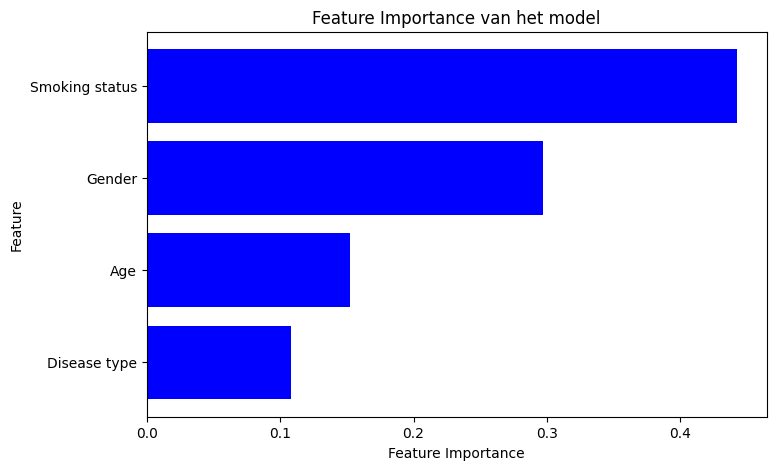

In [214]:
import pandas as pd
import matplotlib.pyplot as plt

# Ophalen van feature importance
feature_importance = model.feature_importances_

# De bijbehorende feature namen
feature_names = ["Age", "Gender", "Smoking status", "Disease type"] 

# Opslaan in een dataframe
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importance})

# Sorteren op belangrijkheid
importance_df = importance_df.sort_values(by="Importance", ascending=False)

# Printen van het resultaat
print(importance_df)

# Visualiseren
plt.figure(figsize=(8, 5))
plt.barh(importance_df["Feature"], importance_df["Importance"], color='blue')
plt.xlabel("Feature Importance")
plt.ylabel("Feature")
plt.title("Feature Importance van het model")
plt.gca().invert_yaxis()  # Belangrijkste feature bovenaan
plt.show()


Conclusie: Er valt te zien dat de smoking status en gender het belangrijkste zijn in het voorspellen van de recovery status. Age en disease type heeft dus minder invloed op het herstel.

### Eindconclusie
Ik ben begonnen met deze onderzoeksvraag: Hoe beïnvloedt rookstatus het type longziekte en de kans op herstel?  

Na de exploratieve data analyse (EDA) en het testen van verschillende modellen ben ik tot de conclusie gekomen dat alleen de featues rookstatus en longziekte niet voldoende is om de herstelstatus te kunnen voorspellen. Daarom heb ik leeftijd en gender toegevoegd aan mijn model.  

Het model presteert met deze 4 features, leeftijd, gender, rookstatus & longziekte, en de RandomForestaclassifier erg goed. Ik heb onderzocht welke features hierbij het belangrijkste zijn en dat zijn rookstatus en gender.  

Dit betekent dat mijn model geschikt is voor de volgende onderzoeksvraag:  
Kan er op basis van gender en rookstatus bepaald worden of iemand hersteld of niet hersteld?  

Het antwoord hierop is ja, dit model kan bepalen op basis van gender en rookstatus of iemand hersteld.